[参考](https://qiita.com/nymwa/items/4542b45837a10766890b)  
言語処理100本ノック 2020 第9章: RNN, CNN   
@nymwa

In [2]:
import re
import spacy
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import optuna

# 80

In [3]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [4]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    t_index = [categories.index(line[0]) for line in dataset]
    dataset_t = []
    for index in t_index:
        label = [0]*4
        label[index] = 1
        dataset_t.append(label)
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [5]:
train_x, train_t = read_feature_dataset('data/train.txt')
valid_x, valid_t = read_feature_dataset('data/valid.txt')
test_x, test_t = read_feature_dataset('data/test.txt')

In [6]:
counter = Counter([
    x
    for sent in train_x
    for x in sent
])

vocab_in_train = [
    token
    for token, freq in counter.most_common()
    if freq > 1
]
len(vocab_in_train)

9700

In [7]:
vocab_in_train

['-',
 "'",
 'to',
 ',',
 '...',
 "'s",
 'in',
 'on',
 'UPDATE',
 ':',
 'as',
 'of',
 'for',
 'The',
 'US',
 'To',
 'the',
 'and',
 '$',
 '"',
 'In',
 'Of',
 'at',
 'a',
 '(',
 ')',
 'With',
 'Is',
 'For',
 'A',
 'And',
 'with',
 'after',
 'New',
 '?',
 'Kardashian',
 ';',
 'On',
 'China',
 'up',
 'by',
 'Kim',
 'After',
 'says',
 '1',
 'At',
 'is',
 'STOCKS',
 '!',
 'Fed',
 'From',
 'new',
 "n't",
 'ECB',
 '2',
 'from',
 'her',
 'Wall',
 'It',
 'shares',
 'Says',
 'FOREX',
 'data',
 'First',
 'About',
 'Miley',
 'Cyrus',
 'Euro',
 'CEO',
 'over',
 'West',
 'Dollar',
 'You',
 'St',
 'she',
 'May',
 'bln',
 'Chris',
 'Over',
 'Ukraine',
 'Will',
 'Stocks',
 'More',
 'Kanye',
 'As',
 'Be',
 'Up',
 'Are',
 'Google',
 'be',
 '.',
 'Justin',
 'Bieber',
 'off',
 'Billion',
 'I',
 'Star',
 'profit',
 'euro',
 '2014',
 'GLOBAL',
 'Bank',
 'are',
 'Time',
 'out',
 'RPT',
 'but',
 'Not',
 'How',
 'sales',
 'deal',
 'it',
 'more',
 'That',
 'UK',
 'that',
 'Day',
 'Gold',
 'pct',
 'What',
 'Apple

In [8]:
vocab_list = ['[UNK]'] + vocab_in_train
vocab_dict = {x:n for n, x in enumerate(vocab_list)}

In [9]:
vocab_dict

{'[UNK]': 0,
 '-': 1,
 "'": 2,
 'to': 3,
 ',': 4,
 '...': 5,
 "'s": 6,
 'in': 7,
 'on': 8,
 'UPDATE': 9,
 ':': 10,
 'as': 11,
 'of': 12,
 'for': 13,
 'The': 14,
 'US': 15,
 'To': 16,
 'the': 17,
 'and': 18,
 '$': 19,
 '"': 20,
 'In': 21,
 'Of': 22,
 'at': 23,
 'a': 24,
 '(': 25,
 ')': 26,
 'With': 27,
 'Is': 28,
 'For': 29,
 'A': 30,
 'And': 31,
 'with': 32,
 'after': 33,
 'New': 34,
 '?': 35,
 'Kardashian': 36,
 ';': 37,
 'On': 38,
 'China': 39,
 'up': 40,
 'by': 41,
 'Kim': 42,
 'After': 43,
 'says': 44,
 '1': 45,
 'At': 46,
 'is': 47,
 'STOCKS': 48,
 '!': 49,
 'Fed': 50,
 'From': 51,
 'new': 52,
 "n't": 53,
 'ECB': 54,
 '2': 55,
 'from': 56,
 'her': 57,
 'Wall': 58,
 'It': 59,
 'shares': 60,
 'Says': 61,
 'FOREX': 62,
 'data': 63,
 'First': 64,
 'About': 65,
 'Miley': 66,
 'Cyrus': 67,
 'Euro': 68,
 'CEO': 69,
 'over': 70,
 'West': 71,
 'Dollar': 72,
 'You': 73,
 'St': 74,
 'she': 75,
 'May': 76,
 'bln': 77,
 'Chris': 78,
 'Over': 79,
 'Ukraine': 80,
 'Will': 81,
 'Stocks': 82,
 'Mo

In [10]:
def sent_to_ids(sent):
    return tf.constant([vocab_dict[x if x in vocab_dict else '[UNK]'] for x in sent], dtype=tf.int64)

In [11]:
print(train_x[0])
print(sent_to_ids(train_x[0]).numpy())

['White', 'House', 'Science', 'Fair', 'Will', 'Focus', 'On', 'Girls', 'In', 'STEM']
[ 482  454 3026 1563   81 2095   38  941   21    0]


In [12]:
def dataset_to_ids(dataset):
    return [sent_to_ids(x) for x in dataset]

In [13]:
train_s = dataset_to_ids(train_x)
valid_s = dataset_to_ids(valid_x)
test_s = dataset_to_ids(test_x)

# 81

In [14]:
max_len = 0
for x in train_s:
    if x.shape[0] > max_len:
        max_len = x.shape[0]
for x in valid_s:
    if x.shape[0] > max_len:
        max_len = x.shape[0]
max_len

25

In [15]:
def padding_zero(data, max_len):
    ret = []
    for i in range(len(data)):
        zero = [0] * (max_len - data[i].shape[0])
        ret.append(tf.concat([data[i], zero], 0))
    return tf.stack(ret)

In [16]:
train_s = padding_zero(train_s, max_len)
train_t = tf.stack(train_t)
valid_s = padding_zero(valid_s, max_len)
valid_t = tf.stack(valid_t)
test_s = padding_zero(test_s, max_len)
test_t = tf.stack(test_t)

In [17]:
train_s.shape

TensorShape([10684, 25])

In [18]:
train_t.shape

TensorShape([10684, 4])

In [19]:
def loss(t, y):
    return tf.keras.backend.mean(tf.keras.losses.categorical_crossentropy(t,y))
def acc(t,y):
    return tf.keras.backend.mean(tf.keras.metrics.categorical_accuracy(t,y))

In [119]:
class RNN81(tf.keras.Model):
    def __init__(self, v_size, e_size, h_size, c_size, dropout=0.2):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(
            input_dim=v_size, 
            output_dim=e_size,
            mask_zero=True
        )
        self.rnn = tf.keras.layers.LSTM(
            h_size
        )
        self.out = tf.keras.layers.Dense(
            c_size
        )

    def call(self, x):
        x = self.emb(x)
        x = self.rnn(x)
        y = tf.nn.softmax(self.out(x))
        return y

In [20]:
model = RNN81(len(vocab_dict), 300, 50, 4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )
model.build(train_s.shape)
model.summary()

Model: "rn_n81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2910300   
_________________________________________________________________
lstm (LSTM)                  multiple                  70200     
_________________________________________________________________
dense (Dense)                multiple                  204       
Total params: 2,980,704
Trainable params: 2,980,704
Non-trainable params: 0
_________________________________________________________________


In [21]:
y = model(test_s)
t = test_t
acc(t, y).numpy()

0.33083832

# 82

In [22]:
!rm -r ./log/82

rm: ./log/82: No such file or directory


In [23]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/82',
    histogram_freq=1,
    write_images=True
)

In [24]:
%reload_ext tensorboard
%tensorboard --logdir log/82 --port 6006 --bind_all --reload_multifile true

In [25]:
history = model.fit(train_s,train_t,
                    epochs=10, 
                    validation_data=(valid_s, valid_t),
                    verbose=1,
                    callbacks=[tb_cb]
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/10
10684/10684 [==============================] - 36s 3ms/sample - loss: 1.0872 - accuracy: 0.5654 - val_loss: 0.9036 - val_accuracy: 0.7051
Epoch 2/10
10684/10684 [==============================] - 23s 2ms/sample - loss: 0.8408 - accuracy: 0.7069 - val_loss: 0.7204 - val_accuracy: 0.7530
Epoch 3/10
10684/10684 [==============================] - 24s 2ms/sample - loss: 0.6853 - accuracy: 0.7583 - val_loss: 0.6354 - val_accuracy: 0.7642
Epoch 4/10
10684/10684 [==============================] - 24s 2ms/sample - loss: 0.5652 - accuracy: 0.7902 - val_loss: 0.7456 - val_accuracy: 0.7148
Epoch 5/10
10684/10684 [==============================] - 27s 3ms/sample - loss: 0.4601 - accuracy: 0.8237 - val_loss: 0.5969 - val_accuracy: 0.7650
Epoch 6/10
10684/10684 [==============================] - 31s 3ms/sample - loss: 0.4000 - accuracy: 0.8454 - val_loss: 0.5037 - val_accuracy: 0.8121
Epoch 7/10
10684/10684 [==============================] -

In [26]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.9313927
評価データでの正解率 : 0.86601794


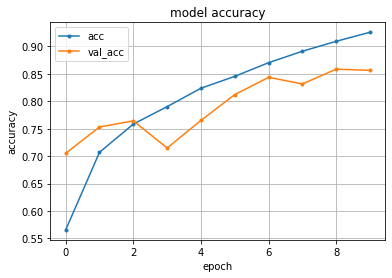

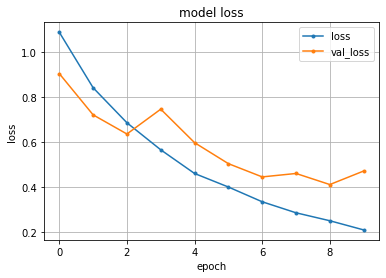

In [27]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 83

In [28]:
model = RNN81(len(vocab_dict), 300, 50, 4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )
model.build(train_s.shape)
model.summary()

Model: "rn_n81_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2910300   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  70200     
_________________________________________________________________
dense_1 (Dense)              multiple                  204       
Total params: 2,980,704
Trainable params: 2,980,704
Non-trainable params: 0
_________________________________________________________________


In [29]:
!rm -r ./log/83

In [30]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/83',
    histogram_freq=1,
    write_images=True
)

In [33]:
%reload_ext tensorboard
%tensorboard --logdir log/83 --bind_all --reload_multifile true

In [34]:
history = model.fit(train_s,train_t,
                    epochs=10, 
                    validation_data=(valid_s, valid_t),
                    verbose=1,
                    callbacks=[tb_cb],
                    batch_size=1024
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/10
10684/10684 [==============================] - 17s 2ms/sample - loss: 1.2936 - accuracy: 0.4153 - val_loss: 1.2184 - val_accuracy: 0.4746
Epoch 2/10
10684/10684 [==============================] - 13s 1ms/sample - loss: 1.1902 - accuracy: 0.4902 - val_loss: 1.1735 - val_accuracy: 0.5195
Epoch 3/10
10684/10684 [==============================] - 10s 976us/sample - loss: 1.1622 - accuracy: 0.5305 - val_loss: 1.1613 - val_accuracy: 0.5307
Epoch 4/10
10684/10684 [==============================] - 12s 1ms/sample - loss: 1.1539 - accuracy: 0.5391 - val_loss: 1.1564 - val_accuracy: 0.5322
Epoch 5/10
10684/10684 [==============================] - 13s 1ms/sample - loss: 1.1498 - accuracy: 0.5432 - val_loss: 1.1530 - val_accuracy: 0.5367
Epoch 6/10
10684/10684 [==============================] - 11s 1ms/sample - loss: 1.1467 - accuracy: 0.5557 - val_loss: 1.1500 - val_accuracy: 0.5382
Epoch 7/10
10684/10684 [==============================]

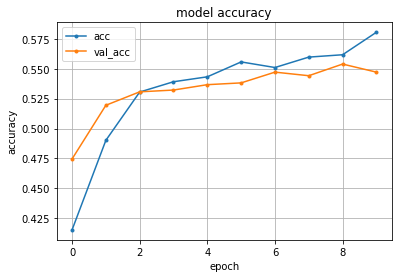

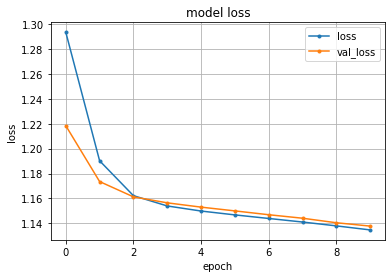

In [35]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 84

In [19]:
from gensim.models import KeyedVectors
vectors = KeyedVectors.load('./data/GoogleNews-vectors-negative300.kv', mmap='r')

In [37]:
model = RNN81(len(vocab_dict), 300, 50, 4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )
model.build(train_s.shape)
model.summary()

Model: "rn_n81_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  2910300   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  70200     
_________________________________________________________________
dense_2 (Dense)              multiple                  204       
Total params: 2,980,704
Trainable params: 2,980,704
Non-trainable params: 0
_________________________________________________________________


In [38]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.24962561
評価データでの正解率 : 0.23877245


In [39]:
model.emb.weights[0].numpy()[7]

array([-0.04281515, -0.03222609,  0.02717478, -0.01079017,  0.01432205,
        0.00952346, -0.02143468,  0.03200585,  0.01753246,  0.0238525 ,
        0.0377828 ,  0.03801748, -0.0154958 ,  0.03517506, -0.03532388,
       -0.03656415,  0.03983731,  0.02405569,  0.0327659 ,  0.00638467,
       -0.04798203, -0.01962084,  0.04075826,  0.0105351 ,  0.04264304,
       -0.04839319, -0.01643003, -0.02046846,  0.0205379 ,  0.03003755,
       -0.04435724, -0.04809241,  0.02727426,  0.01122868, -0.00446954,
       -0.04102534, -0.00685145,  0.01434703,  0.03554419, -0.00493861,
        0.00430236,  0.00269889,  0.04156575,  0.02188497, -0.04138426,
        0.01747691, -0.01851792, -0.04629418, -0.04218064, -0.00875577,
       -0.02688277,  0.01683644, -0.00220109, -0.02332398, -0.00969782,
       -0.01781275, -0.04704031, -0.04306947,  0.0377093 ,  0.01738471,
        0.02333758, -0.02949909,  0.01082999, -0.02495904,  0.01739795,
       -0.02917152, -0.00110637, -0.04466841, -0.01641232, -0.03

In [40]:
tf.constant(vectors['in']).numpy()

array([ 0.0703125 ,  0.08691406,  0.08789062,  0.0625    ,  0.06933594,
       -0.10888672, -0.08154297, -0.15429688,  0.02075195,  0.13183594,
       -0.11376953, -0.03735352,  0.06933594,  0.078125  , -0.10302734,
       -0.09765625,  0.04418945,  0.10253906, -0.06079102, -0.03613281,
       -0.04541016,  0.04736328, -0.12060547, -0.06396484,  0.0022583 ,
        0.03710938, -0.00291443,  0.11767578,  0.06176758,  0.06396484,
        0.08105469, -0.06884766, -0.0213623 ,  0.05517578, -0.08544922,
        0.06884766, -0.12792969, -0.03320312,  0.09863281,  0.17578125,
        0.11083984, -0.03466797, -0.04711914, -0.00848389,  0.03588867,
        0.10302734,  0.02697754, -0.02868652, -0.00512695,  0.10644531,
        0.05981445,  0.09423828,  0.03369141, -0.02709961, -0.09423828,
        0.00102997, -0.04833984,  0.03442383,  0.08105469, -0.11328125,
       -0.08886719,  0.03588867, -0.14550781, -0.24414062, -0.06152344,
        0.05297852,  0.05688477,  0.1796875 ,  0.06103516,  0.08

In [41]:
for i, token in enumerate(vocab_dict):
    if token in vectors:
        model.emb.weights[0][i].assign(tf.constant(vectors[token]))

In [42]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.20806813
評価データでの正解率 : 0.19910179


In [43]:
!rm -r ./log/84

tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/84',
    histogram_freq=1,
    write_images=True
)

%reload_ext tensorboard
%tensorboard --logdir log/84 --bind_all --reload_multifile true

rm: ./log/84: No such file or directory


In [44]:
history = model.fit(train_s,train_t,
                    epochs=100, 
                    validation_data=(valid_s, valid_t),
                    verbose=1,
                    callbacks=[tb_cb],
                    batch_size=1024
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/100
10684/10684 [==============================] - 20s 2ms/sample - loss: 1.2874 - accuracy: 0.4027 - val_loss: 1.1979 - val_accuracy: 0.4573
Epoch 2/100
10684/10684 [==============================] - 12s 1ms/sample - loss: 1.1593 - accuracy: 0.5397 - val_loss: 1.1329 - val_accuracy: 0.5921
Epoch 3/100
10684/10684 [==============================] - 11s 1ms/sample - loss: 1.1084 - accuracy: 0.6645 - val_loss: 1.0921 - val_accuracy: 0.7021
Epoch 4/100
10684/10684 [==============================] - 15s 1ms/sample - loss: 1.0683 - accuracy: 0.7264 - val_loss: 1.0492 - val_accuracy: 0.7440
Epoch 5/100
10684/10684 [==============================] - 14s 1ms/sample - loss: 1.0204 - accuracy: 0.7494 - val_loss: 0.9920 - val_accuracy: 0.7560
Epoch 6/100
10684/10684 [==============================] - 15s 1ms/sample - loss: 0.9527 - accuracy: 0.7583 - val_loss: 0.9086 - val_accuracy: 0.7627
Epoch 7/100
10684/10684 [==========================

Epoch 55/100
10684/10684 [==============================] - 10s 965us/sample - loss: 0.2720 - accuracy: 0.9087 - val_loss: 0.3201 - val_accuracy: 0.8840
Epoch 56/100
10684/10684 [==============================] - 10s 912us/sample - loss: 0.2680 - accuracy: 0.9103 - val_loss: 0.3189 - val_accuracy: 0.8862
Epoch 57/100
10684/10684 [==============================] - 10s 937us/sample - loss: 0.2676 - accuracy: 0.9115 - val_loss: 0.3156 - val_accuracy: 0.8847
Epoch 58/100
10684/10684 [==============================] - 10s 923us/sample - loss: 0.2640 - accuracy: 0.9122 - val_loss: 0.3166 - val_accuracy: 0.8855
Epoch 59/100
10684/10684 [==============================] - 9s 878us/sample - loss: 0.2609 - accuracy: 0.9130 - val_loss: 0.3134 - val_accuracy: 0.8907
Epoch 60/100
10684/10684 [==============================] - 10s 955us/sample - loss: 0.2588 - accuracy: 0.9139 - val_loss: 0.3412 - val_accuracy: 0.8795
Epoch 61/100
10684/10684 [==============================] - 10s 932us/sample - loss

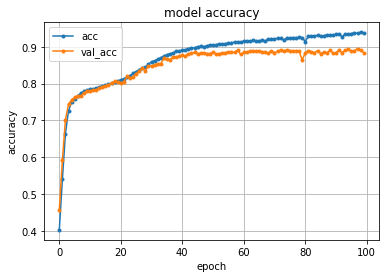

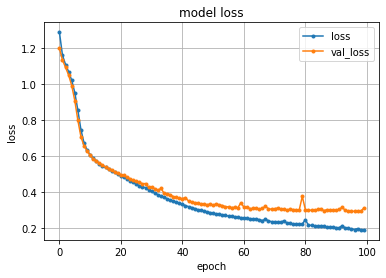

In [45]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [46]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.9247473
評価データでの正解率 : 0.90568864


# 85

In [47]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(
            input_dim=len(vocab_dict), 
            output_dim=300,
            mask_zero=True,
            input_length=max_len,
            name="emb"))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, 25, 300)           2910300   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 128)           186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 3,138,656
Trainable params: 3,138,656
Non-trainable params: 0
_________________________________________________________________


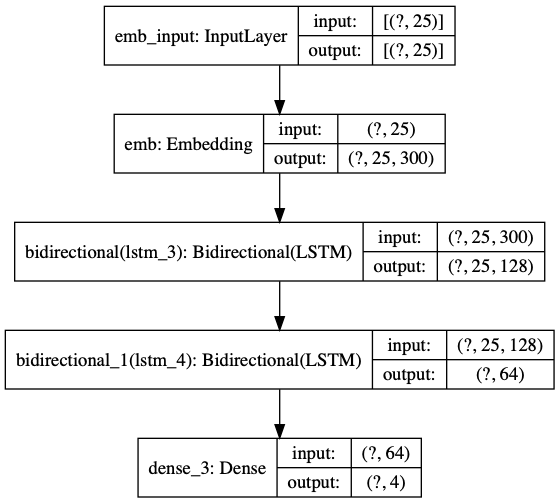

In [48]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [49]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )

In [50]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.22173344
評価データでの正解率 : 0.23128742


In [51]:
for i, token in enumerate(vocab_dict):
    if token in vectors:
        model.get_layer("emb").weights[0][i].assign(tf.constant(vectors[token]))

In [52]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.17549607
評価データでの正解率 : 0.20508982


In [53]:
!rm -r ./log/85

In [54]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/85',
    histogram_freq=1,
    write_images=True
)

In [55]:
%reload_ext tensorboard
%tensorboard --logdir log/85 --port 6006 --bind_all --reload_multifile true

In [56]:
history = model.fit(train_s,train_t,
                    epochs=100, 
                    validation_data=(valid_s, valid_t),
                    verbose=1,
                    callbacks=[tb_cb],
                    batch_size=1024
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/100
10684/10684 [==============================] - 59s 5ms/sample - loss: 1.2669 - accuracy: 0.4159 - val_loss: 1.1696 - val_accuracy: 0.5397
Epoch 2/100
10684/10684 [==============================] - 29s 3ms/sample - loss: 1.1294 - accuracy: 0.6007 - val_loss: 1.0964 - val_accuracy: 0.7395
Epoch 3/100
10684/10684 [==============================] - 27s 3ms/sample - loss: 1.0643 - accuracy: 0.7485 - val_loss: 1.0312 - val_accuracy: 0.7627
Epoch 4/100
10684/10684 [==============================] - 37s 3ms/sample - loss: 0.9878 - accuracy: 0.7672 - val_loss: 0.9381 - val_accuracy: 0.7620
Epoch 5/100
10684/10684 [==============================] - 33s 3ms/sample - loss: 0.8803 - accuracy: 0.7710 - val_loss: 0.8219 - val_accuracy: 0.7672
Epoch 6/100
10684/10684 [==============================] - 27s 3ms/sample - loss: 0.7669 - accuracy: 0.7751 - val_loss: 0.7265 - val_accuracy: 0.7725
Epoch 7/100
10684/10684 [==========================

Epoch 55/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2575 - accuracy: 0.9132 - val_loss: 0.3230 - val_accuracy: 0.8810
Epoch 56/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2556 - accuracy: 0.9146 - val_loss: 0.3195 - val_accuracy: 0.8832
Epoch 57/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.3100 - accuracy: 0.8899 - val_loss: 0.3385 - val_accuracy: 0.8787
Epoch 58/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2521 - accuracy: 0.9160 - val_loss: 0.3086 - val_accuracy: 0.8832
Epoch 59/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2519 - accuracy: 0.9157 - val_loss: 0.3071 - val_accuracy: 0.8907
Epoch 60/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2440 - accuracy: 0.9171 - val_loss: 0.3033 - val_accuracy: 0.8885
Epoch 61/100
10684/10684 [==============================] - 17s 2ms/sample - loss: 0.2376 - ac

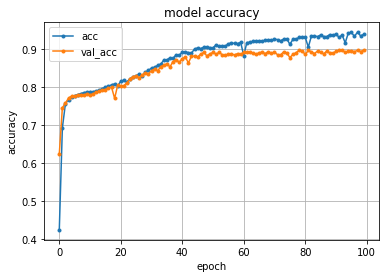

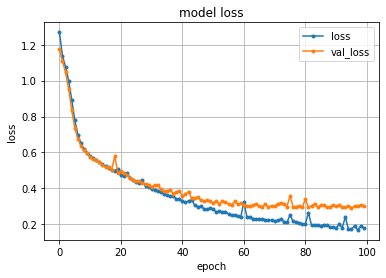

In [64]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 86

In [317]:
class CNN86(tf.keras.Model):
    def __init__(self, v_size, e_size, h_size, c_size, kernel_size=3, dropout=0.2):
        super().__init__()
        self.c_size = c_size
        self.emb = tf.keras.layers.Embedding(input_dim=v_size, 
                                             output_dim=e_size,
                                             mask_zero=True,
                                             input_length=max_len,
                                             name="emb"
                                            )
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.conv = tf.keras.layers.Conv1D(h_size,
                                           kernel_size,
                                           padding="causal",
                                           data_format='channels_last',
                                          )
        self.relu = tf.keras.layers.ReLU()
        self.maxpooling = tf.keras.layers.MaxPooling1D(pool_size=max_len, data_format='channels_last',)
        self.dropout_2 = tf.keras.layers.Dropout(dropout)
        self.out = tf.keras.layers.Dense(c_size)
    def call(self, x):
        x = self.emb(x)
        x = self.dropout_1(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpooling(x)
        x = self.dropout_2(x)
        x = tf.nn.softmax(self.out(x))
        y = tf.reshape(x, (-1, self.c_size))
        return y

In [330]:
model = CNN86(len(vocab_dict), 300, 128, 4, kernel_size=3, dropout=0.5)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,
              metrics=['accuracy']
             )
model.build(test_s.shape)
model.summary()

Model: "cn_n86_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              multiple                  2910300   
_________________________________________________________________
dropout_25 (Dropout)         multiple                  0         
_________________________________________________________________
conv1d_50 (Conv1D)           multiple                  115328    
_________________________________________________________________
re_lu_43 (ReLU)              multiple                  0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
dense_46 (Dense)             multiple                  516

In [331]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.3925496
評価データでの正解率 : 0.41092813


# 87

In [332]:
for i, token in enumerate(vocab_dict):
    if token in vectors:
        model.get_layer("emb").weights[0][i].assign(tf.constant(vectors[token]))

In [333]:
print('学習データでの正解率 :', acc(train_t, model(train_s)).numpy())
print('評価データでの正解率 :', acc(test_t, model(test_s)).numpy())

学習データでの正解率 : 0.35857356
評価データでの正解率 : 0.38323355


In [334]:
!rm -r ./log/87

In [335]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/87',
    histogram_freq=1,
    write_images=True
)

In [336]:
%reload_ext tensorboard
%tensorboard --logdir log/87 --port 6006 --bind_all --reload_multifile true

In [337]:
history = model.fit(train_s,train_t,
                    epochs=50, 
                    validation_data=(valid_s, valid_t),
                    verbose=1,
                    callbacks=[tb_cb],
                    batch_size=1024
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/50
10684/10684 [==============================] - 9s 823us/sample - loss: 1.1099 - accuracy: 0.5468 - val_loss: 0.7455 - val_accuracy: 0.7680
Epoch 2/50
10684/10684 [==============================] - 8s 753us/sample - loss: 0.7451 - accuracy: 0.7443 - val_loss: 0.5537 - val_accuracy: 0.8211
Epoch 3/50
10684/10684 [==============================] - 7s 633us/sample - loss: 0.5706 - accuracy: 0.7996 - val_loss: 0.4449 - val_accuracy: 0.8473
Epoch 4/50
10684/10684 [==============================] - 9s 875us/sample - loss: 0.4628 - accuracy: 0.8386 - val_loss: 0.3781 - val_accuracy: 0.8802
Epoch 5/50
10684/10684 [==============================] - 9s 842us/sample - loss: 0.3958 - accuracy: 0.8653 - val_loss: 0.3324 - val_accuracy: 0.8952
Epoch 6/50
10684/10684 [==============================] - 8s 766us/sample - loss: 0.3334 - accuracy: 0.8870 - val_loss: 0.3013 - val_accuracy: 0.9004
Epoch 7/50
10684/10684 [===========================

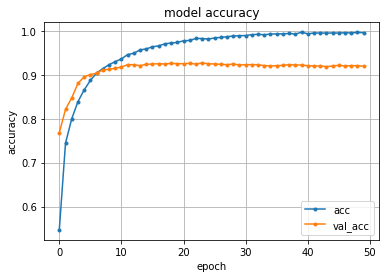

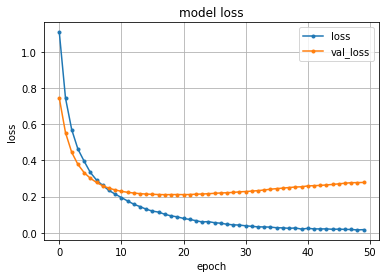

In [338]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 88

In [35]:
tf.keras.backend.clear_session()
!rm -r ./log/88
%reload_ext tensorboard
%tensorboard --logdir log/88 --port 6006 --bind_all --reload_multifile true

In [38]:
class CNN88(tf.keras.Model):
    def __init__(self, v_size, e_size, h_size, c_size, padding, activation, dropout_1, dropout_2,kernel_size=3):
        super().__init__()
        self.c_size = c_size
        self.emb = tf.keras.layers.Embedding(input_dim=v_size, 
                                             output_dim=e_size,
                                             mask_zero=True,
                                             input_length=max_len,
                                             name="emb"
                                            )
        self.dropout_1 = tf.keras.layers.Dropout(dropout_1)
        self.conv = tf.keras.layers.Conv1D(h_size,
                                           kernel_size,
                                           padding=padding,
                                           data_format='channels_last',
                                           activation=activation,
                                           name="conv1d"
                                          )
        self.maxpooling = tf.keras.layers.MaxPooling1D(pool_size=max_len, name="maxpool")
        self.dropout_2 = tf.keras.layers.Dropout(dropout_2)
        self.out = tf.keras.layers.Dense(c_size,
                                         activation='softmax'
                                        )
    def call(self, x):
        x = self.emb(x)
        x = self.dropout_1(x)
        x = self.conv(x)
        x = self.maxpooling(x)
        x = self.dropout_2(x)
        x = self.out(x)
        y = tf.reshape(x, (-1, self.c_size))
        return y

In [40]:
def objective(trial):
    # 調整したいハイパーパラメータの設定
    padding = trial.suggest_categorical('padding', ['same', 'causal'])
    h_size = trial.suggest_int('h_size', 10, 300) # ユニット数
    dropout_1 = trial.suggest_uniform('dropout_1', 0, 1) # ドロップアウト率
    dropout_2 = trial.suggest_uniform('dropout_2', 0, 1) # ドロップアウト率
    activation = trial.suggest_categorical('activation', ['relu','sigmoid','tanh']) # 活性化関数
    learning_index = trial.suggest_uniform('learning_index', -3, 2) 
    learning_rate = 10**learning_index
    batch_size = trial.suggest_int('batch_size', 100, 10684)

    log_dir = './log/88/' + 'model_' + "_".join(map(str,[padding, h_size, dropout_1, dropout_2, activation, learning_rate, batch_size]))
    tb_cb = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_images=True,
    )
    
    tf.keras.backend.clear_session()
    
    # 学習モデルの構築と学習の開始
    model = CNN88(len(vocab_dict), 300, h_size, 4, padding, activation, dropout_1, dropout_2)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                    loss=loss,
                    metrics=['accuracy'])
    history = model.fit(train_s, train_t, 
                        verbose=0,
                        epochs=20,
                        validation_data=(valid_s, valid_t),
                        callbacks=[tb_cb],
                        batch_size=batch_size)

    # 最小値探索なので
    return -np.amax(history.history['val_accuracy'])

In [41]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler())
study.optimize(objective, show_progress_bar=True)

/Users/soya/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,


[I 2020-04-29 11:23:45,581] Finished trial#0 with value: -0.405688613653183 with parameters: {'padding': 'causal', 'h_size': 129, 'dropout_1': 0.2185700965006917, 'dropout_2': 0.5534229688782764, 'activation': 'tanh', 'learning_index': 1.0168137796504553, 'batch_size': 9459}. Best is trial#0 with value: -0.405688613653183.
[I 2020-04-29 11:27:26,904] Finished trial#1 with value: -0.6452096104621887 with parameters: {'padding': 'causal', 'h_size': 185, 'dropout_1': 0.6454176530560781, 'dropout_2': 0.015827960088214632, 'activation': 'tanh', 'learning_index': -0.14313062046821123, 'batch_size': 8488}. Best is trial#1 with value: -0.6452096104621887.
[I 2020-04-29 11:29:03,981] Finished trial#2 with value: -0.5082335472106934 with parameters: {'padding': 'causal', 'h_size': 68, 'dropout_1': 0.812146815189169, 'dropout_2': 0.9105934601361666, 'activation': 'relu', 'learning_index': -0.7119002552808262, 'batch_size': 10049}. Best is trial#1 with value: -0.6452096104621887.
[I 2020-04-29 11:

[I 2020-04-29 12:54:03,098] Finished trial#25 with value: -0.40643712878227234 with parameters: {'padding': 'causal', 'h_size': 280, 'dropout_1': 0.43456341152145, 'dropout_2': 0.6310777311231399, 'activation': 'relu', 'learning_index': 1.1766641610498598, 'batch_size': 963}. Best is trial#20 with value: -0.8914670944213867.
[I 2020-04-29 12:58:46,638] Finished trial#26 with value: -0.405688613653183 with parameters: {'padding': 'causal', 'h_size': 260, 'dropout_1': 0.1657426956400887, 'dropout_2': 0.8195351990886901, 'activation': 'sigmoid', 'learning_index': -0.0031679545228307676, 'batch_size': 2098}. Best is trial#20 with value: -0.8914670944213867.
[I 2020-04-29 13:02:06,692] Finished trial#27 with value: -0.405688613653183 with parameters: {'padding': 'same', 'h_size': 229, 'dropout_1': 0.57261992368597, 'dropout_2': 0.634773533693172, 'activation': 'relu', 'learning_index': 0.8246306523964653, 'batch_size': 3074}. Best is trial#20 with value: -0.8914670944213867.
[I 2020-04-29 1

[I 2020-04-29 14:17:17,889] Finished trial#49 with value: -0.7694610953330994 with parameters: {'padding': 'causal', 'h_size': 242, 'dropout_1': 0.0004096332398487723, 'dropout_2': 0.4215199816587994, 'activation': 'relu', 'learning_index': -0.35901531249371643, 'batch_size': 748}. Best is trial#36 with value: -0.8929640650749207.
[I 2020-04-29 14:21:03,306] Finished trial#50 with value: -0.409431129693985 with parameters: {'padding': 'causal', 'h_size': 225, 'dropout_1': 0.3750137161758835, 'dropout_2': 0.9534497275036846, 'activation': 'sigmoid', 'learning_index': -2.759257757745391, 'batch_size': 4922}. Best is trial#36 with value: -0.8929640650749207.
[I 2020-04-29 14:24:09,249] Finished trial#51 with value: -0.8929640650749207 with parameters: {'padding': 'causal', 'h_size': 180, 'dropout_1': 0.2925168838452613, 'dropout_2': 0.3571434121028817, 'activation': 'relu', 'learning_index': -0.16126310277030753, 'batch_size': 118}. Best is trial#36 with value: -0.8929640650749207.
[I 202

KeyboardInterrupt: 

In [42]:
print('best_params')
print(study.best_params)
print('-1 x best_value')
print(-study.best_value)

best_params
{'padding': 'causal', 'h_size': 270, 'dropout_1': 0.21875304255133837, 'dropout_2': 0.5772679024904684, 'activation': 'relu', 'learning_index': -0.01756104149219713, 'batch_size': 137}
-1 x best_value
0.8929640650749207


# 89. 事前学習済み言語モデルからの転移学習

In [20]:
from transformers import *

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [22]:
len(tokenizer.get_vocab())

28996

In [23]:
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [24]:
def read_for_bert(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    t_index = [categories.index(line[0]) for line in dataset]
    dataset_t = []
    for index in t_index:
        label = [0]*4
        label[index] = 1
        dataset_t.append(tf.constant(label))
    dataset_x = [tf.constant(tokenizer.encode(line[1]), dtype=tf.int32) for line in dataset]
    return dataset_x, dataset_t

bert_train_x, bert_train_t = read_for_bert('data/train.txt')
bert_valid_x, bert_valid_t = read_for_bert('data/valid.txt')
bert_test_x, bert_test_t = read_for_bert('data/test.txt')

In [25]:
max_len = 0
for x in bert_train_x:
    if x.shape[0] > max_len:
        max_len = x.shape[0]
for x in bert_valid_x:
    if x.shape[0] > max_len:
        max_len = x.shape[0]
max_len

40

In [26]:
def padding_zero(data, max_len):
    ret = []
    for i in range(len(data)):
        zero = [0] * (max_len - data[i].shape[0])
        ret.append(tf.concat([data[i], zero], 0))
    return tf.stack(ret)

In [27]:
bert_train_x = padding_zero(bert_train_x, max_len)
bert_train_t = tf.stack(bert_train_t)
bert_valid_x = padding_zero(bert_valid_x, max_len)
bert_valid_t = tf.stack(bert_valid_t)
bert_test_x = padding_zero(bert_test_x, max_len)
bert_test_t = tf.stack(bert_test_t)

In [28]:
tf.keras.backend.clear_session()